<a href="https://colab.research.google.com/github/Jerlyn/vibecode/blob/main/SDXL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install diffusers transformers accelerate safetensors peft bitsandbytes xformers --break-system-packages
!pip install opencv-python pillow --break-system-packages

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 MB 7.6 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [3]:
import os

# Create folders for your training data
os.makedirs('/content/training_data/mythosobeah', exist_ok=True)
os.makedirs('/content/output', exist_ok=True)

print("Folders created successfully!")

Folders created successfully!


In [4]:
from google.colab import files
import shutil

# Upload all your JPG and TXT files
print("Please upload ALL your image files (.jpg) and caption files (.txt)")
print("Make sure each image has a matching .txt file with the same name")
print("Example: image_1.jpg and image_1.txt")

uploaded = files.upload()

# Move files to training folder
for filename in uploaded.keys():
    shutil.move(filename, f'/content/training_data/mythosobeah/{filename}')

print(f"\n✓ Uploaded {len(uploaded)} files to training folder")

Please upload ALL your image files (.jpg) and caption files (.txt)
Make sure each image has a matching .txt file with the same name
Example: image_1.jpg and image_1.txt


Saving image_19.txt to image_19.txt
Saving image_20.txt to image_20.txt
Saving image_20.jpg to image_20.jpg
Saving image_19.jpg to image_19.jpg
Saving image_18.txt to image_18.txt
Saving image_18.jpg to image_18.jpg
Saving image_17.txt to image_17.txt
Saving image_17.jpg to image_17.jpg
Saving image_16.txt to image_16.txt
Saving image_16.jpg to image_16.jpg
Saving image_15.txt to image_15.txt
Saving image_15.jpg to image_15.jpg
Saving image_14.txt to image_14.txt
Saving image_14.jpg to image_14.jpg
Saving image_13.txt to image_13.txt
Saving image_13.jpg to image_13.jpg
Saving image_12.txt to image_12.txt
Saving image_12.jpg to image_12.jpg
Saving image_11.txt to image_11.txt
Saving image_11.jpg to image_11.jpg
Saving image_10.txt to image_10.txt
Saving image_10.jpg to image_10.jpg
Saving image_9.txt to image_9.txt
Saving image_9.jpg to image_9.jpg
Saving image_8.txt to image_8.txt
Saving image_8.jpg to image_8.jpg
Saving image_7.txt to image_7.txt
Saving image_7.jpg to image_7.jpg
Savi

Found 20 images
Found 20 caption files
✓ image_15.jpg has matching caption
✓ image_19.jpg has matching caption
✓ image_13.jpg has matching caption
✓ image_6.jpg has matching caption
✓ image_16.jpg has matching caption
✓ image_2.jpg has matching caption
✓ image_20.jpg has matching caption
✓ image_12.jpg has matching caption
✓ image_11.jpg has matching caption
✓ image_9.jpg has matching caption
✓ image_17.jpg has matching caption
✓ image_10.jpg has matching caption
✓ image_1.jpg has matching caption
✓ image_18.jpg has matching caption
✓ image_8.jpg has matching caption
✓ image_7.jpg has matching caption
✓ image_3.jpg has matching caption
✓ image_14.jpg has matching caption
✓ image_5.jpg has matching caption
✓ image_4.jpg has matching caption

Sample caption:
mythosobeah sketch, black and white line art, two men in conversation seated at table, younger person with short curly afro hair and blazer on left, older distinguished man with goatee and chain necklace with ornate medallion on righ

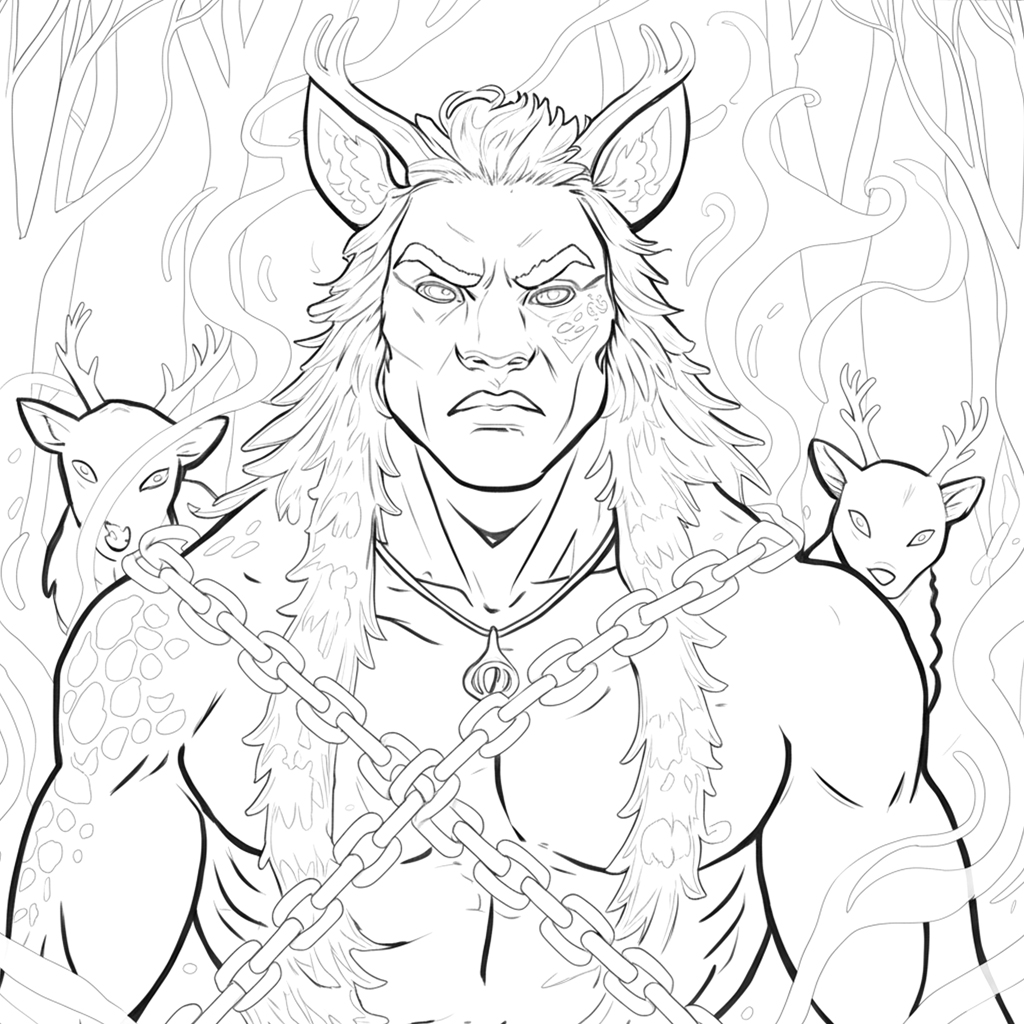

In [5]:
import os
from PIL import Image

# Check what we have
training_path = '/content/training_data/mythosobeah'
images = [f for f in os.listdir(training_path) if f.endswith('.jpg')]
captions = [f for f in os.listdir(training_path) if f.endswith('.txt')]

print(f"Found {len(images)} images")
print(f"Found {len(captions)} caption files")

# Verify pairs
for img in images:
    img_name = img.replace('.jpg', '')
    txt_name = img_name + '.txt'
    if txt_name in captions:
        print(f"✓ {img} has matching caption")
    else:
        print(f"✗ {img} MISSING caption file!")

# Show a sample
if images:
    sample_img = Image.open(os.path.join(training_path, images[0]))
    sample_txt = open(os.path.join(training_path, captions[0])).read()
    print(f"\nSample caption:\n{sample_txt}")
    display(sample_img)

In [44]:
# Training settings optimized for SDXL with 20 images
training_config = {
    "pretrained_model": "stabilityai/stable-diffusion-xl-base-1.0",
    "output_dir": "/content/output/mythosobeah_lora_sdxl",
    "train_data_dir": "/content/training_data/mythosobeah",

    # Training parameters - SDXL specific
    "resolution": 1024,  # SDXL uses 1024x1024
    "train_batch_size": 1,
    "gradient_accumulation_steps": 4,
    "max_train_steps": 3000,  # SDXL trains faster
    "learning_rate": 1e-4,  # Lower learning rate for SDXL
    "lr_scheduler": "constant",
    "lr_warmup_steps": 0,

    # LoRA specific
    "rank": 32,
    "lora_alpha": 32,

    # Saving
    "save_steps": 500,
    "checkpointing_steps": 500,
}

print("✓ SDXL Configuration set!")
print(f"Resolution: {training_config['resolution']}")
print(f"Will train for {training_config['max_train_steps']} steps")

✓ SDXL Configuration set!
Resolution: 1024
Will train for 3000 steps


In [45]:
import torch
from diffusers import StableDiffusionPipeline, DDPMScheduler
from transformers import CLIPTextModel, CLIPTokenizer
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm
import os

# Dataset class for SDXL
class TextImageDataset(Dataset):
    def __init__(self, data_dir, tokenizer, size=1024):
        self.data_dir = data_dir
        self.tokenizer = tokenizer
        self.size = size

        # Get all image files
        self.image_files = [f for f in os.listdir(data_dir) if f.endswith('.jpg')]

        # Image preprocessing for SDXL
        self.transform = transforms.Compose([
            transforms.Resize(size, interpolation=transforms.InterpolationMode.BILINEAR),
            transforms.CenterCrop(size),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        img_path = os.path.join(self.data_dir, img_name)
        txt_path = img_path.replace('.jpg', '.txt')

        # Load image
        image = Image.open(img_path).convert('RGB')
        image = self.transform(image)

        # Load caption
        with open(txt_path, 'r') as f:
            caption = f.read().strip()

        # Tokenize caption
        tokens = self.tokenizer(
            caption,
            padding="max_length",
            max_length=self.tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt"
        )

        return {
            "pixel_values": image,
            "input_ids": tokens.input_ids[0]
        }

print("✓ SDXL Dataset class ready!")

✓ SDXL Dataset class ready!


In [46]:
# Load SDXL models
print("Loading SDXL base models...")
tokenizer = CLIPTokenizer.from_pretrained(
    training_config["pretrained_model"],
    subfolder="tokenizer"
)

text_encoder = CLIPTextModel.from_pretrained(
    training_config["pretrained_model"],
    subfolder="text_encoder"
)

# Freeze text encoder
text_encoder.requires_grad_(False)

# Create dataset and dataloader
print("Creating dataset...")
dataset = TextImageDataset(
    training_config["train_data_dir"],
    tokenizer,
    training_config["resolution"]
)

dataloader = DataLoader(
    dataset,
    batch_size=training_config["train_batch_size"],
    shuffle=True
)

print(f"✓ Dataset created with {len(dataset)} images")
print(f"✓ Will train for {training_config['max_train_steps']} steps")
print(f"✓ Using resolution: {training_config['resolution']}x{training_config['resolution']}")

Loading SDXL base models...


tokenizer_config.json:   0%|          | 0.00/737 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

Creating dataset...
✓ Dataset created with 20 images
✓ Will train for 3000 steps
✓ Using resolution: 1024x1024


In [47]:
from diffusers import UNet2DConditionModel
from peft import LoraConfig, get_peft_model

print("Loading UNet and setting up LoRA...")

# Load UNet
unet = UNet2DConditionModel.from_pretrained(
    training_config["pretrained_model"],
    subfolder="unet"
)

# Configure LoRA
lora_config = LoraConfig(
    r=training_config["rank"],
    lora_alpha=training_config["lora_alpha"],
    init_lora_weights="gaussian",
    target_modules=["to_k", "to_q", "to_v", "to_out.0"],
)

# Apply LoRA to UNet
unet = get_peft_model(unet, lora_config)

print("✓ LoRA layers configured")
unet.print_trainable_parameters()

Loading UNet and setting up LoRA...


config.json: 0.00B [00:00, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/10.3G [00:00<?, ?B/s]

✓ LoRA layers configured
trainable params: 46,448,640 || all params: 2,613,912,324 || trainable%: 1.7770


In [48]:
# Save final LoRA weights
final_save_path = os.path.join(training_config["output_dir"], "final")
os.makedirs(final_save_path, exist_ok=True)

# Save using PEFT
unwrapped_unet = accelerator.unwrap_model(unet)
unwrapped_unet.save_pretrained(final_save_path)

print(f"✓ Final model saved to: {final_save_path}")

# Also save to Google Drive
drive_path = '/content/drive/MyDrive/mythosobeah_lora_final'
os.makedirs(drive_path, exist_ok=True)
unwrapped_unet.save_pretrained(drive_path)

print(f"✓ Backup saved to Google Drive: {drive_path}")
print("\n🎉 Training complete! Your LoRA is ready to use.")

✓ Final model saved to: /content/output/mythosobeah_lora_sdxl/final
✓ Backup saved to Google Drive: /content/drive/MyDrive/mythosobeah_lora_final

🎉 Training complete! Your LoRA is ready to use.


In [4]:
from diffusers import StableDiffusionXLPipeline
import torch

print("Loading your trained SDXL LoRA...")

# Load SDXL pipeline
pipe = StableDiffusionXLPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    torch_dtype=torch.float16,
    variant="fp16",
    use_safetensors=True
)
pipe = pipe.to("cuda")

# Load your trained LoRA weights
from peft import PeftModel
pipe.unet = PeftModel.from_pretrained(pipe.unet, final_save_path)

print("✓ SDXL LoRA loaded successfully!\n")

# Disable safety checker
pipe.safety_checker = None
pipe.requires_safety_checker = False

# Generate test image with SDXL-appropriate prompt
prompt = "mythosobeah, grayscale illustration, black and white with gray tones, Caribbean person with traditional jewelry and elaborate necklaces, solid black hair, detailed ornate patterns in background, controlled ink linework, professional comic art style"

negative_prompt = "colored, full color, photorealistic, photograph, 3d render, overly decorative patterns, messy linework, realistic photo"

print(f"Generating image with prompt:\n{prompt}\n")

image = pipe(
    prompt=prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=30,
    guidance_scale=7.5,
    height=1024,
    width=1024
).images[0]

display(image)

# Save the test image
image.save('/content/test_generation_sdxl.png')
print("\n✓ Test image saved!")

KeyboardInterrupt: 

In [50]:
import shutil
from google.colab import files

shutil.make_archive('/content/mythosobeah_lora', 'zip', final_save_path)
files.download('/content/mythosobeah_lora.zip')

print("✓ LoRA downloaded!")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

✓ LoRA downloaded!


In [1]:
prompts = [
    "mythosobeah sketch, black and white line art, elderly Caribbean woman with head wrap and wisdom in her eyes",
    "mythosobeah sketch, black and white line art, young man with dreadlocks fishing by the ocean",
    "mythosobeah sketch, black and white line art, Caribbean family celebration with traditional clothing"
]

for i, prompt in enumerate(prompts):
    print(f"\nGenerating image {i+1}...")
    image = pipe(prompt, num_inference_steps=30, guidance_scale=7.5).images[0]
    image.save(f'/content/test_{i+1}.png')
    display(image)


Generating image 1...


NameError: name 'pipe' is not defined

In [2]:
prompt = "mythosobeah sketch, black and white line art, simple clean linework, coloring book style, no shading, no gradients, bold outlines, elderly Caribbean woman with elaborate head wrap, traditional jewelry, detailed patterns in background"

negative_prompt = "photorealistic, shading, grayscale, realistic, 3d render, photograph, detailed shading, soft lighting"

image = pipe(
    prompt,
    negative_prompt=negative_prompt,
    num_inference_steps=30,
    guidance_scale=7.5
).images[0]

NameError: name 'pipe' is not defined

In [3]:
prompt = "mythosobeah, simple black ink line drawing, coloring book page, no shading, clean outlines only, elderly woman with head wrap"
negative_prompt = "shading, gradient, photorealistic, realistic, 3d, grayscale shading, soft edges"

image = pipe(prompt, negative_prompt=negative_prompt, guidance_scale=8.5).images[0]
display(image)

NameError: name 'pipe' is not defined

In [33]:
# Disable safety checker
pipe.safety_checker = None
pipe.requires_safety_checker = False

print("✓ Safety checker disabled")

✓ Safety checker disabled


  0%|          | 0/30 [00:00<?, ?it/s]

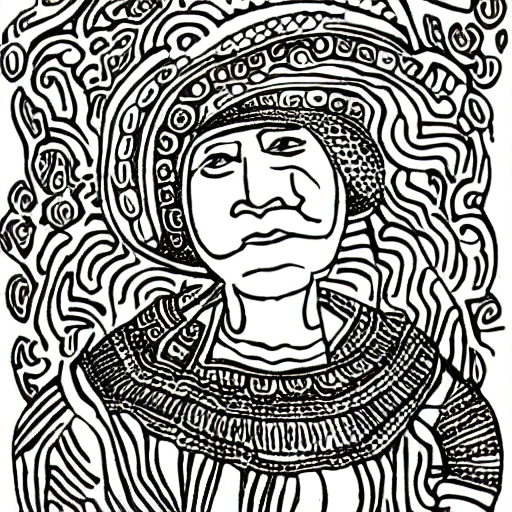

In [34]:
prompt = "mythosobeah, simple black ink line drawing, coloring book page, no shading, clean outlines only, elderly woman with head wrap, traditional jewelry"
negative_prompt = "shading, gradient, photorealistic, realistic, 3d, grayscale shading, soft edges"

image = pipe(
    prompt,
    negative_prompt=negative_prompt,
    guidance_scale=8.5,
    num_inference_steps=30
).images[0]

display(image)
image.save('/content/test_no_safety.png')


Generating test 1...


  0%|          | 0/30 [00:00<?, ?it/s]

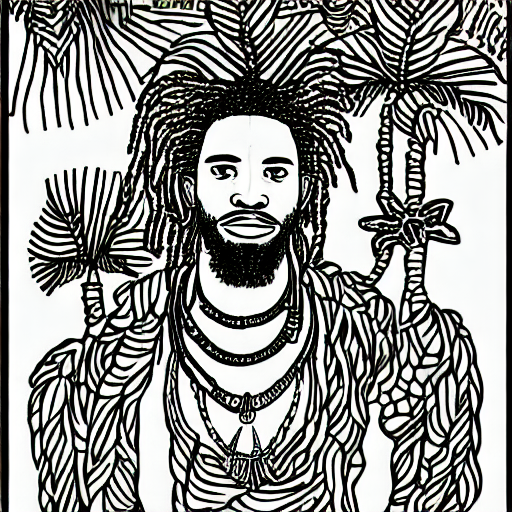


Generating test 2...


  0%|          | 0/30 [00:00<?, ?it/s]

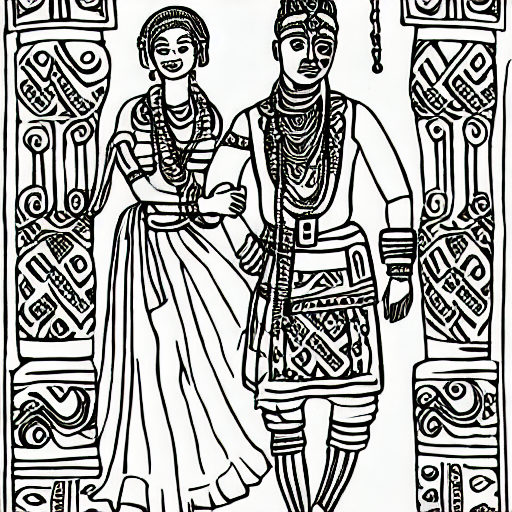


Generating test 3...


  0%|          | 0/30 [00:00<?, ?it/s]

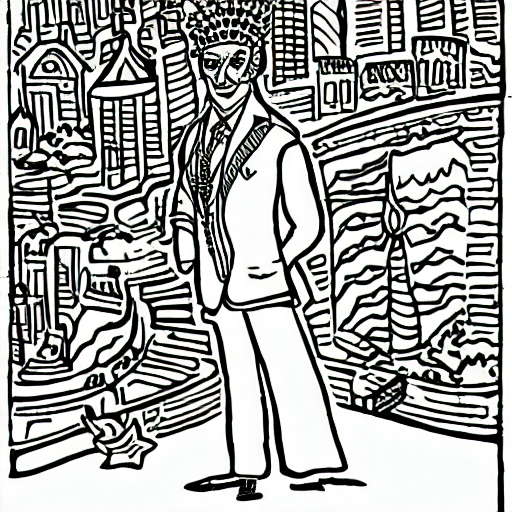

In [35]:
# Test different subjects in your style
test_prompts = [
    "mythosobeah, simple black ink line drawing, coloring book page, young Caribbean man with dreadlocks and traditional necklace, palm trees in background",

    "mythosobeah, simple black ink line drawing, coloring book page, Caribbean couple in formal traditional attire with elaborate patterns",

    "mythosobeah, simple black ink line drawing, coloring book page, person with horns in business attire, urban background"
]

negative_prompt = "shading, gradient, photorealistic, realistic, 3d, grayscale shading, soft edges, photograph"

for i, prompt in enumerate(test_prompts):
    print(f"\nGenerating test {i+1}...")
    image = pipe(
        prompt,
        negative_prompt=negative_prompt,
        guidance_scale=8.5,
        num_inference_steps=30
    ).images[0]
    image.save(f'/content/mythosobeah_test_{i+1}.png')
    display(image)

In [42]:
from google.colab import files
import shutil
import os

# Remove old caption files
txt_files = [f for f in os.listdir('/content/training_data/mythosobeah') if f.endswith('.txt')]
for txt in txt_files:
    os.remove(f'/content/training_data/mythosobeah/{txt}')

print(f"Deleted {len(txt_files)} old caption files")

# Upload new ones
print("\nPlease upload ALL your updated .txt files (all 20 at once):")
uploaded = files.upload()

# Move them to training folder
for filename in uploaded.keys():
    if filename.endswith('.txt'):
        shutil.move(filename, f'/content/training_data/mythosobeah/{filename}')

print(f"\n✓ Uploaded {len(uploaded)} new caption files!")

Deleted 20 old caption files

Please upload ALL your updated .txt files (all 20 at once):


Saving image_18.txt to image_18.txt
Saving image_20.txt to image_20.txt
Saving image_20.jpg to image_20.jpg
Saving image_19.txt to image_19.txt
Saving image_19.jpg to image_19.jpg
Saving image_18.jpg to image_18.jpg
Saving image_17.txt to image_17.txt
Saving image_17.jpg to image_17.jpg
Saving image_16.txt to image_16.txt
Saving image_16.jpg to image_16.jpg
Saving image_15.txt to image_15.txt
Saving image_15.jpg to image_15.jpg
Saving image_14.txt to image_14.txt
Saving image_14.jpg to image_14.jpg
Saving image_13.txt to image_13.txt
Saving image_13.jpg to image_13.jpg
Saving image_12.txt to image_12.txt
Saving image_12.jpg to image_12.jpg
Saving image_11.txt to image_11.txt
Saving image_11.jpg to image_11.jpg
Saving image_10.txt to image_10.txt
Saving image_10.jpg to image_10.jpg
Saving image_9.txt to image_9.txt
Saving image_9.jpg to image_9.jpg
Saving image_8.txt to image_8.txt
Saving image_8.jpg to image_8.jpg
Saving image_7.txt to image_7.txt
Saving image_7.jpg to image_7.jpg
Savi

In [43]:
import os

files = os.listdir('/content/training_data/mythosobeah')
txt_files = [f for f in files if f.endswith('.txt')]

print(f"Found {len(txt_files)} caption files")

# Show first caption as sample
with open(f'/content/training_data/mythosobeah/{txt_files[0]}', 'r') as f:
    print(f"\nSample caption ({txt_files[0]}):")
    print(f.read())

Found 20 caption files

Sample caption (image_5.txt):
mythosobeah, black and white illustration with minimal grayscale shading, two men in conversation seated at table, younger person with short curly afro hair and blazer on left, older distinguished man with goatee and chain necklace with ornate medallion on right, solid dark gray fill for the older man's hair and mustache, framed portrait of woman on wall behind them with mid-tone gray wash for clothing, indoor setting with horizontal lines suggesting window blinds, intimate discussion scene, formal attire, intergenerational moment, clean, highly detailed ink linework
